#　(1) TWIP model
O.Bouaziz et al., Mater. Sci. Eng. A31-321 (2001) 246-249 <br>
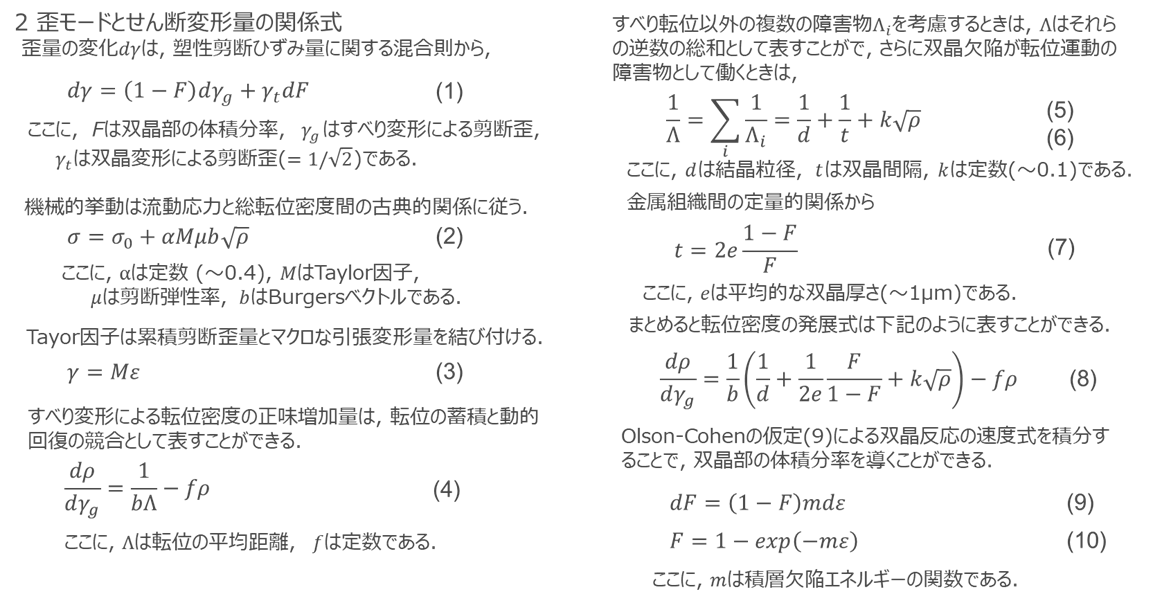<br>

In [94]:
!pip install optuna

In [95]:
import math as m
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

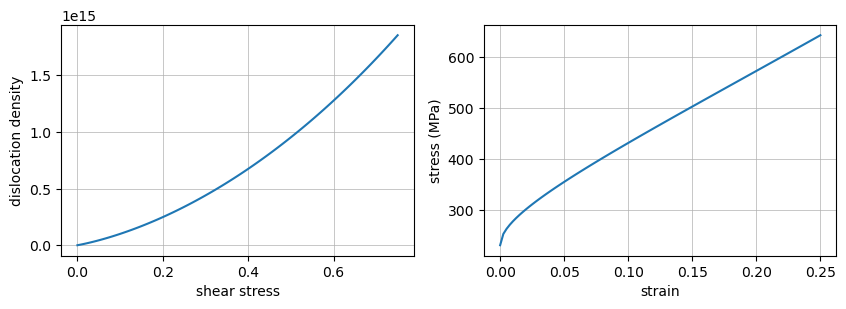

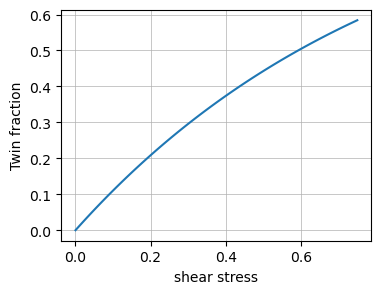

In [96]:
ads = 0.4   # Constant for dislocation spacing
Mtf = 3     # Taylor factor
brg = 1e-10  # Bergers vector (m)
miu = 8e10  # Shear modulus
dgs = 5e-6  # Grain size (m)
ett = 6e-7  # average twin thickness which is independent of strain #この数値はどこから来た??

s0 = 2.3e8  # flow stress
kds = 0.011  # Constant for dislocation spacing
fdr = 3     # Constant for dislocation recovery
msf = 1.17  # function of stacking fault energy 1.17

''' 一階微分方程式の右辺 '''


def frac(gam):  # eq(10)
    return 1-m.exp(-msf*gam)  # ε＝γと置いている??


def fde(ro, gam):  # eqs(8)をリターン
    F0 = 1-m.exp(-msf*gam)  # 　　　　　　　　　　　　　　　　　　　　　　　　　#frac使わないのはなぜ？
    return 1/brg*(1/dgs+F0/(2*ett*(1-F0))+kds*m.sqrt(ro))-fdr*ro  # eqs(8)をリターン


''' 一階微分方程式のRunge_Kutta法(4次)による解法 '''


def runge_kutta(x0, h, ts, f):  # xは転位密度、#tsはせん断ひずみγ　歪がなければ（γ＝０）、転位密度（ρ）はゼロを初期状態とする
    x = x0  # initial value
    xs = []
    for t in ts:
        xs.append(x)
        k1 = h*f(x, t)
        k2 = h*f(x+0.5*k1, t+0.5*h)
        k3 = h*f(x+0.5*k2, t+0.5*h)
        k4 = h*f(x+k3, t+h)
        x += (k1+2*k2+2*k3+k4)/6
    return xs


''' 計算範囲を設定し, Runge-Kutta法で計算実行 '''
a, b, N = 0, 0.25, 101
h = (b-a)/N
ips = np.linspace(a, b, N)
tps = ips*Mtf  # γのこと
xps = runge_kutta(0, h, tps, fde)  # せん断ひずみγ　と　転位密度の微分方程式
# eqs(2)　xにxpsの解＝転位密度を代入して、σを求める
sigs = [(s0+ads*Mtf*miu*brg*m.sqrt(x))/1e6 for x in xps]
fracs = [frac(t) for t in tps]

# 剪断歪と転位密度のグラフ表示
plt.figure(figsize=(10, 3)), plt.subplot(1, 2, 1)
plt.plot(tps, xps)
plt.xlabel("shear stress"), plt.ylabel(
    "dislocation density"), plt.grid(linewidth=0.5)
# 真応力と真歪の表示
plt.subplot(1, 2, 2)
plt.plot(ips, sigs)
plt.xlabel("strain"), plt.ylabel("stress (MPa)"), plt.grid(linewidth=0.5)
plt.show()
# 剪断歪と転位密度のグラフ表示
plt.figure(figsize=(4, 3)), plt.subplot(1, 1, 1)
plt.plot(tps, fracs)
plt.xlabel("shear stress"), plt.ylabel(
    "Twin fraction"), plt.grid(linewidth=0.5)
plt.show()

### TWIPクラスとして定義
モデル定数と材料変数を別々に設定できるようにする.<br>
各関数をclass内に定義できるようにする. <br>

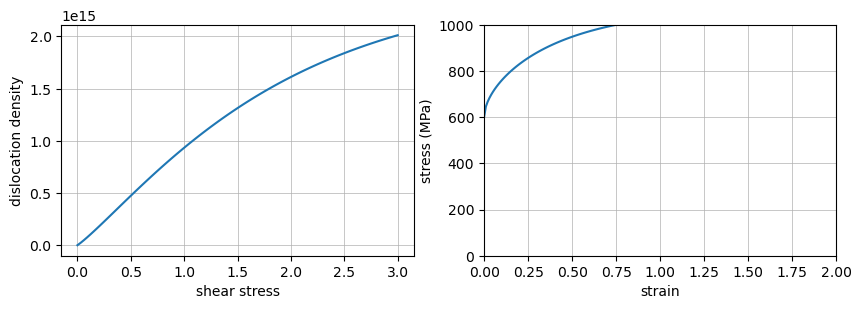

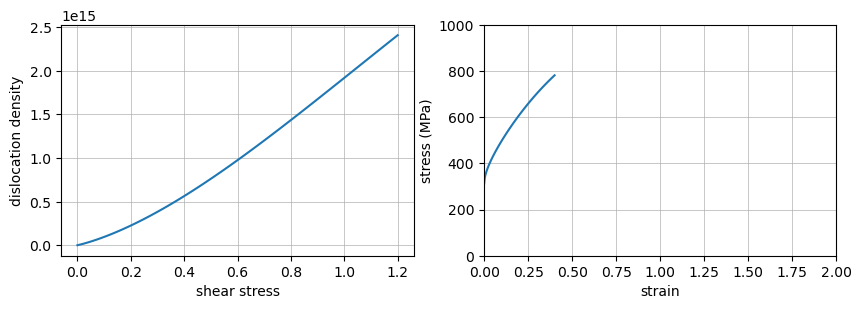

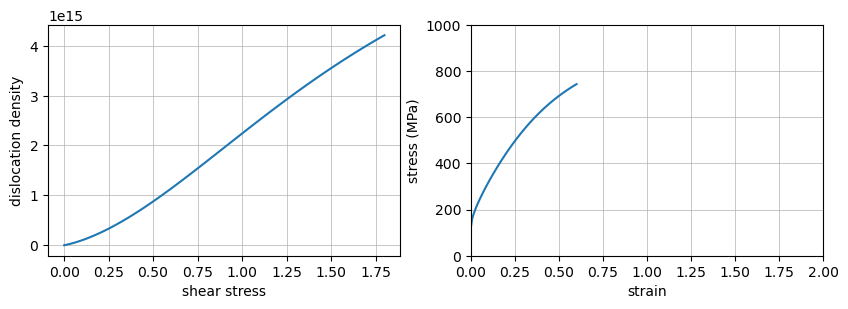

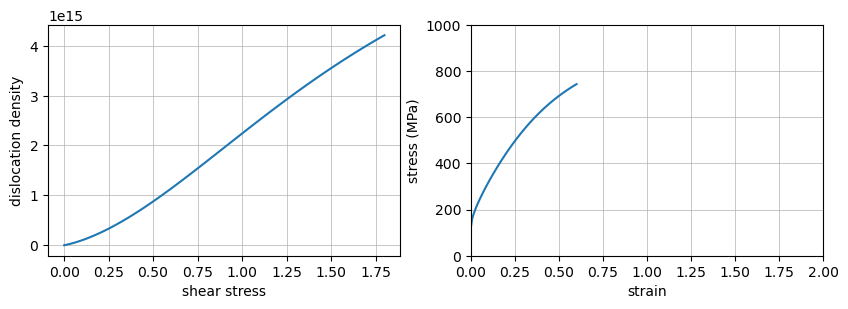

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import math as m

''' TWIP modeling class '''

class Twip:
    ads = 0.4   # Constant for dislocation spacing
    Mtf = 3     # Taylor factor
    brg = 1e-10  # Bergers vector (m)
    ett = 0.6e-6  # average twin thickness which is independent of strain
    x0 = 1e10  # initial dislocation density 2025/1/8追加

    ''' TWIPクラスの初期化(引数: 材料定数) '''

    def __init__(self, sm, d, s, k, f, sf):
        self.miu = sm   # Shear modulus
        self.dgs = d    # Grain size (m)
        self.s0 = s     # flow stress
        # Constant for dislocation spacing -> Constant for dislocation density (by hasegawa)
        self.kds = k
        self.fdr = f    # Constant for dislocation recovery
        self.msf = sf  # function of stacking fault energy
        # self.alpha = alpha # Sensitivity for grain size -> new definition (by hasegawa)
        # self.beta = beta # Sensitivity for twin spacing -> new definition (by hasegawa)
        # self.ett = (0.0025*self.dgs*1e9+23)*1e-9

    ''' TWIPモデルの定数 '''

    def set_consts(self, a, M, b, e):  # model constants
        self.ads, self.Mtf, self.brg, self.ett = a, M, b, e

    ''' 材料に関する定数 '''

    def set_mater_params(self, sm, d, s, k, f, sf):  # metrial parameters
        self.miu, self.dgs, self.s0 = sm, d, s
        self.kds, self.fdr, self.msf = k, f, sf

    ''' 一階微分方程式の右辺 (引数:転位密度ro,剪断歪gam) '''

    def fde(self, ro, gam):
        F0 = 1-m.exp(-1.17*self.msf*gam)
        # ett = (0.0025*self.dgs+23)*1e-9
        # アルファ、ベータを追加
        return 1/self.brg*(1/self.dgs+F0/(2*self.ett*(1-F0)+1e-6)+self.kds*m.sqrt(ro))-self.fdr*ro

    ''' 一階微分方程式のRunge_Kutta法(4次)による解法 '''

    def runge_kutta(self, x0, h, ts, f):
        x = x0  # initial value
        xs = []
        for t in ts:
            xs.append(x)
            k1 = h*f(x, t)
            k2 = h*f(x+0.5*k1, t+0.5*h)
            k3 = h*f(x+0.5*k2, t+0.5*h)
            k4 = h*f(x+k3, t+h)
            x += (k1+2*k2+2*k3+k4)/6
        return xs

    ''' ポスト処理: 結果の表示 '''

    def ss_plot(self, tps, xps, ips, sigs):

        # 剪断歪と転位密度のグラフ表示
        plt.figure(figsize=(10, 3)), plt.subplot(1, 2, 1)
        plt.plot(tps, xps)
        plt.xlabel("shear stress"), plt.ylabel(
            "dislocation density"), plt.grid(linewidth=0.5)

        # 真応力と真歪の表示
        plt.subplot(1, 2, 2)
        plt.plot(ips, sigs)
        plt.xlabel("strain"), plt.ylabel("stress (MPa)"), plt.grid(
            linewidth=0.5), plt.ylim([0, 1000]), plt.xlim([0, 2])
        plt.show()

    ''' TWIPモデルのメイン関数 '''

    def twip_main(self, a, b, N, plot_option=True):
        h = (b-a)/N
        ips = np.linspace(a, b, N)
        tps = ips*self.Mtf
        xps = self.runge_kutta(self.x0, h, tps, self.fde)
        sigs = [(self.s0+self.ads*self.Mtf*self.miu *
                 self.brg*m.sqrt(x))/1e6 for x in xps]
        if plot_option:
            self.ss_plot(tps, xps, ips, sigs)
        return ips, sigs


''' TWIP classに材料初期値を格納 
　　(引数: sm=せん断弾性率,d=粒径,s0＝flow_stress(=sigma_0),kds=転位密度-転位平均距離の比例定数,fdr＝式(8)の定数,msd＝積層欠陥エネルギーの関数) '''
''' Twipクラスからインスタンスdを作成'''
d = Twip(sm=8e10, d=5e-6, s=6e8, k=0.011, f=3, sf=0)  # for AISI409 steel →

# d.set_mater_params(8e10,5e-6,3.1e8,0.011,3,1.35) # for AISI304L steel

''' 計算範囲を設定し, Runge-Kutta法で計算実行 (引数: a,b,N) '''  # a,bは引張変形量εを入れること
r1 = d.twip_main(0, 1, 101, plot_option=True)  # TWIPモデルのメイン関数 引張歪量a-bと刻みNを代入

d.set_mater_params(8e10, 5e-6, 3.1e8, 0.011, 3, 1.35)  # for AISI304L steel
r2 = d.twip_main(0, 0.4, 101, plot_option=True)

d.set_mater_params(8e10, 5e-6, 1.2e8, 0.011, 3, 1.95)  # for Fe-Mn-C steel
r3 = d.twip_main(0, 0.6, 101, plot_option=True)

d.set_mater_params(8e10, 5e-6, 1.2e8, 0.011, 3, 1.95)  # for brass
r3 = d.twip_main(0, 0.6, 101, plot_option=True)

## ここまで、桃井さんのコード

-----------------------------

# (2) 黄銅へのTWIPモデル適用

### 真応力－真ひずみ

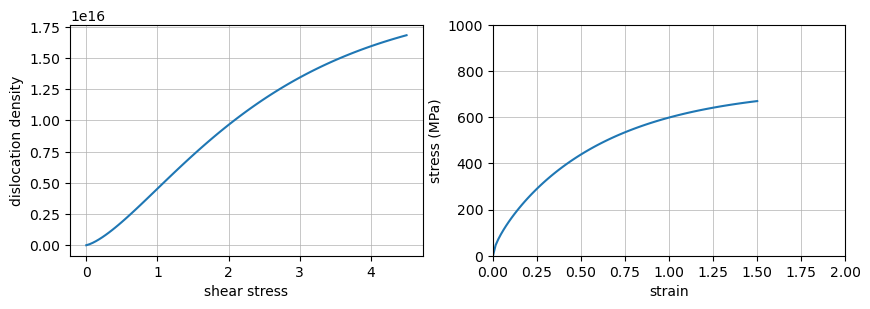

In [98]:
''' TWIP classに材料初期値を格納
　　(引数: sm=せん断弾性率=剛性率,　60/40黄銅～70/30黄銅＝38～41GPa
          d=粒径,
          s0＝flow_stress(?),
          kds=転位密度-転位平均距離の比例定数,
          fdr＝式(8)の定数,
          msd＝積層欠陥エネルギーの関数
          ) '''
''' Twipクラスからインスタンスdを作成'''

d = Twip(
    sm=4.3e10,  # せん断弾性率=剛性率　△
    d=3e-6,  # 粒径　△
    s=0,  # sigma_0　△
    k=0.04,  # 転位密度-転位平均距離の比例定数　★
    f=3,  # 式(8)の定数  ★
    sf=0,  # 積層欠陥エネルギーの関数　★
    # alpha=1, #粒径への感度
    # beta=1, #双晶間隔への感度
)

ips, sigs = d.twip_main(0, 1.5, 101, plot_option=True)  # ipsはd.twip_mainから出す

In [99]:
N = 151

result_Zn = pd.DataFrame(index=range(0, N), columns=(
    ["pure_Cu", "Cu-10Zn", "Cu-20Zn", "Cu-30Zn"]))

In [100]:
k_list = [0.03, 0.038, 0.047, 0.050]  # pureCu,Zn=10%,20%,30%
# sf = [-0.1,-0.3,-0.8,-1.0]
sf = [0.00014, 0.0014, 0.0014, 0.0014]  # Cu-30Znの数値を文献より引用

for i, (k, sf) in enumerate(zip(k_list, sf)):
    d = Twip(sm=4.1e10, d=200e-6, s=0, k=k, f=3, sf=sf)
    ips, sigs = d.twip_main(0, 1.5, N, plot_option=False)

    result_Zn.iloc[:, i] = sigs
    result_Zn["ips"] = ips.round(2)

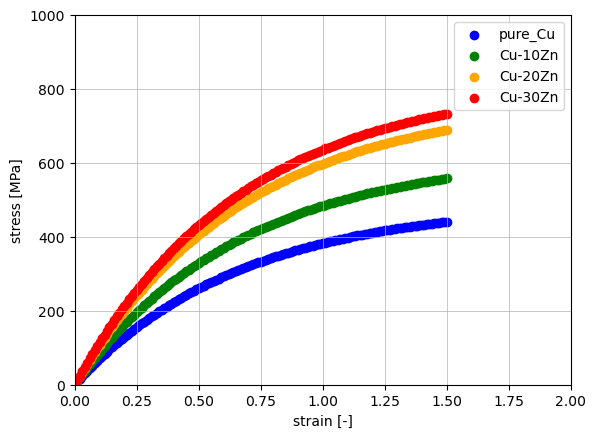

In [101]:
x = result_Zn.ips

fig, ax = plt.subplots()

ax.scatter(x=x, y=result_Zn["pure_Cu"], color="blue", label="pure_Cu")
ax.scatter(x=x, y=result_Zn["Cu-10Zn"], color="green", label="Cu-10Zn")
ax.scatter(x=x, y=result_Zn["Cu-20Zn"], color="orange", label="Cu-20Zn")
ax.scatter(x=x, y=result_Zn["Cu-30Zn"], color="red", label="Cu-30Zn")

plt.xlabel("strain [-]"), plt.xlim([0, 2])
plt.ylabel("stress [MPa]"), plt.ylim([0, 1000])
plt.grid(linewidth=0.5)

ax.legend()
plt.show()

# (3) Optunaを使ったTWIPモデルのSSカーブへのフィッティング

### データ読み込み、関数の定義

In [102]:
df1_10Zn = pd.read_pickle("df1_10Zn.pkl")
df1_20Zn = pd.read_pickle("df1_20Zn.pkl")
df1_30Zn = pd.read_pickle("df1_30Zn.pkl")
df1_PureCu = pd.read_pickle("df1_PureCu.pkl")

In [103]:
df1_list = [
    df1_10Zn,
    df1_20Zn,
    df1_30Zn,
    df1_PureCu
]

In [104]:
for i, df in enumerate(df1_list):
    df["Predict"] = 0

In [105]:
d = Twip(sm=4.1e10, d=200e-6, s=0, k=0.03, f=3, sf=0.0014)
ips, sigs = d.twip_main(0, 1.5, 151, plot_option=False)
result = pd.DataFrame(columns=["ips", "sigs"])
result["ips"] = ips.round(2)
result["sigs"] = sigs

In [106]:
df = df1_PureCu  # 表示したいデータを入力

for i in range(len(df.index)):
    df.iloc[i, 3] = result["sigs"].loc[(
        df.iloc[i, 0] == result.ips)].values.astype("float")

/tmp/ipykernel_223/250238171.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '194.19176489058384' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, 3] = result["sigs"].loc[(


<Axes: xlabel='epsilon', ylabel='Predict'>

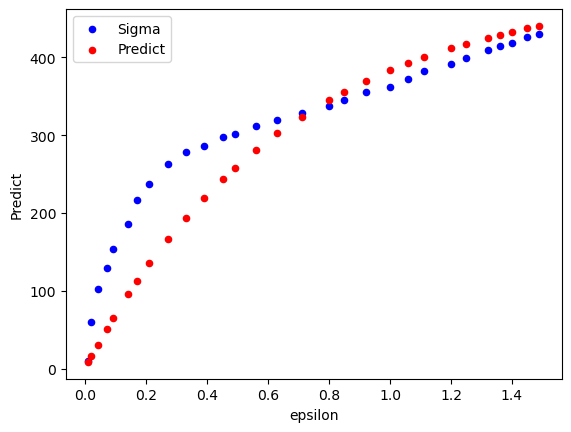

In [107]:
ax = df.plot.scatter(x="epsilon", y="sigma", color='blue', label='Sigma')
df.plot.scatter(x="epsilon", y="Predict", color='red', label='Predict', ax=ax)

In [108]:
""" 計算値が決まったら実験値と計算値の誤差を計算する関数 （単体）"""


def func_error(df):
    error = []
    error.append(np.sqrt(sum(np.square(df.sigma - df.Predict)/len(df.index))))
    error_sum = sum(error)
    return (error_sum)

In [109]:
func_error(df)

52.66584218890762

## Optunaによるパラメータフィッティング

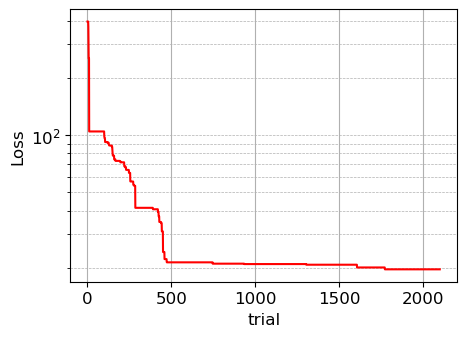

In [192]:
''' 最適化したいデータをdf_optに格納'''
df_opt = df1_PureCu

''' Optunaの設定'''


def objective(trial):
    param = {
        # sm": trial.suggest_float('sm', 3.5e10, 4.5e10),
        "k": trial.suggest_float('k', 0, 0.1),
        "f": trial.suggest_float('f', 0, 100),
        "sf": trial.suggest_float('sf', 0, 10),
        # "alpha": trial.suggest_float('alpha', 0, 100),
        # "beta": trial.suggest_float('beta', 0, 100),
        # 切片s=s0+k0*d^(-1/2)とおき、Hall-petch則のパラメータs0,k0も合わせみの対象とし、粒径を入れればsが決まるようにする。
        "s0": trial.suggest_float('s0', 1e6, 1e9),
        "k0": trial.suggest_float('k0', 0, 1e7)
    }

    gs = 200e-6  # 粒径を定義
    d = Twip(sm=4e10, d=gs, s=param["s0"]+param["k0"]*gs**(-0.5), k=param["k"],
             f=param["f"],
             sf=param["sf"],
             # alpha=param["alpha"],
             # beta=param["beta"]
             )  # G=4E10と置いた必要に応じて変えてください

    ips, sigs = d.twip_main(0, 1.5, 151, plot_option=False)
    result = pd.DataFrame(columns=["ips", "sigs"])
    result["ips"] = ips.round(2)
    result["sigs"] = sigs

    for i in range(len(df_opt.index)):
        df_opt.iloc[i, 3] = result["sigs"].loc[(
            df_opt.iloc[i, 0] == result.ips)].values.astype("float")

    return func_error(df_opt)


if __name__ == '__main__':
    # studyオブジェクト生成
    random_sampler = optuna.samplers.RandomSampler()
    study = optuna.create_study(direction="minimize", sampler=random_sampler)

    # 最適化実行
    optuna.logging.disable_default_handler()

    study.optimize(objective, n_trials=100)

    study.sampler = optuna.samplers.TPESampler()
    study.optimize(objective, n_trials=2000)

    epoches = []    # 試行回数格納用
    values = []    # best_value格納用
    best = 100000    # 適当に最大値を格納しておく
    # best更新を行う
    for i in study.trials:
        if best > i.value:
            best = i.value
        epoches.append(i.number+1)
        values.append(best)

    # グラフ設定等
    plt.rcParams["font.size"] = 12
    plt.figure(figsize=(5, 3.54), dpi=100)
    plt.plot(epoches, values, color="red")
    plt.xlabel("trial"), plt.ylabel("Loss"), plt.grid()
    plt.yscale("log")
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    plt.show()

In [193]:
print("Best parameters: ", study.best_params)
print("Best value: ", study.best_value)

Best parameters:  {'k': 0.03796745928121878, 'f': 6.5424945630823395, 'sf': 0.4023854909502642, 's0': 18425750.574723087, 'k0': 600801.6348058621}
Best value:  19.64574304488011


## 最適化後のSSカーブ確認

<Axes: xlabel='epsilon', ylabel='Predict'>

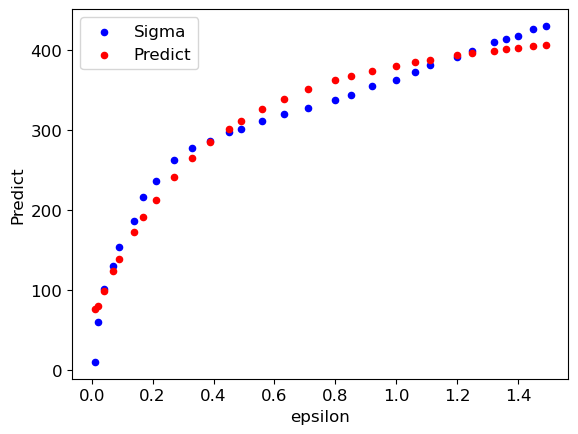

In [194]:
# best_sm = study.best_params["sm"]
best_k = study.best_params["k"]
best_f = study.best_params["f"]
best_sf = study.best_params["sf"]
# best_alpha = study.best_params["alpha"] #粒径への感度追加
# best_beta = study.best_params["beta"]#双晶間隔への感度追加
best_s0 = study.best_params["s0"]
best_k0 = study.best_params["k0"]

gs = 200e-6
d = Twip(sm=4e10, d=gs,
         s=best_s0+best_k0*gs**(-0.5),
         k=best_k, f=best_f, sf=best_sf)
ips, sigs = d.twip_main(0, 1.5, 151, plot_option=False)
result = pd.DataFrame(columns=["ips", "sigs"])
result["ips"] = ips.round(2)
result["sigs"] = sigs

for i in range(len(df1_10Zn.index)):
    df_opt.iloc[i, 3] = result["sigs"].loc[(
        df_opt.iloc[i, 0] == result.ips)].values.astype("float")

ax = df_opt.plot.scatter(x="epsilon", y="sigma", color='blue', label='Sigma')
df_opt.plot.scatter(x="epsilon", y="Predict",
                    color='red', label='Predict', ax=ax)

In [195]:
# df_summary = pd.DataFrame(index=result.ips,columns=["Cu","10Zn","20Zn","30Zn"])

In [196]:
df_summary.loc[:, "Cu"] = result.sigs.values

In [209]:
df_summary.to_csv("df_summary.csv", index=True, encoding="utf-8-sig")

              Cu        10Zn        20Zn        30Zn
ips                                                 
0.00   61.388842   97.284248   50.109095   84.309399
0.01   70.999972  103.911642   60.514646    90.86707
0.02   80.530423  112.832243   70.998672  101.363719
0.03   89.692319  121.693376   81.211331  111.670844
0.04   98.539758  130.474226   91.212236  121.890267
...          ...         ...         ...         ...
1.46  405.619211  488.846574  645.306829  713.877466
1.47  405.993998  489.167724  646.413326  716.371017
1.48  406.363751  489.482247   647.50484  718.857022
1.49  406.728552  489.790285  648.581616  721.335559
1.50  407.088483  490.091974   649.64389  723.806705

[151 rows x 4 columns]


In [210]:
df_summary

,Cu,10Zn,20Zn,30Zn
ips,,,,
0.00,61.388842,97.284248,50.109095,84.309399
0.01,70.999972,103.911642,60.514646,90.86707
0.02,80.530423,112.832243,70.998672,101.363719
0.03,89.692319,121.693376,81.211331,111.670844
0.04,98.539758,130.474226,91.212236,121.890267
...,...,...,...,...
1.46,405.619211,488.846574,645.306829,713.877466
1.47,405.993998,489.167724,646.413326,716.371017
1.48,406.363751,489.482247,647.50484,718.857022


Text(0.5, 0, 'Strain')

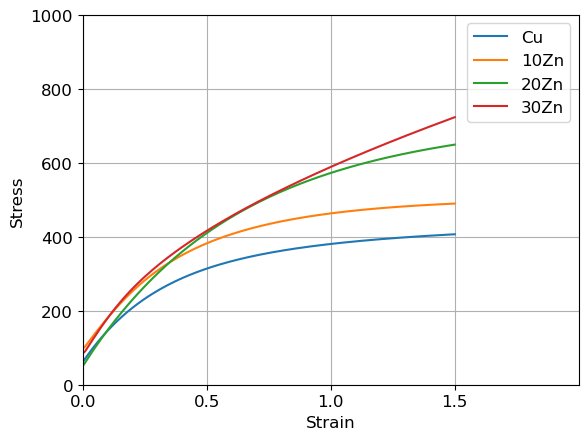

In [198]:
df_summary.plot()
plt.ylim([0, 1000])
plt.xlim([0, 2])
plt.xticks(np.arange(0, 2, 0.5))
plt.grid(True)
plt.ylabel("Stress")
plt.xlabel("Strain")

## Optuna　粒径への影響のみ最適化

In [199]:
df3_3m = pd.read_pickle("df3_3m.pkl")
df3_10m = pd.read_pickle("df3_10m.pkl")
df3_20m = pd.read_pickle("df3_20m.pkl")
df3_200m = pd.read_pickle("df3_200m.pkl")

In [200]:
df3_list = [df3_3m, df3_10m, df3_20m, df3_200m]

for i, df in enumerate(df3_list):
    df["Predict"] = 0

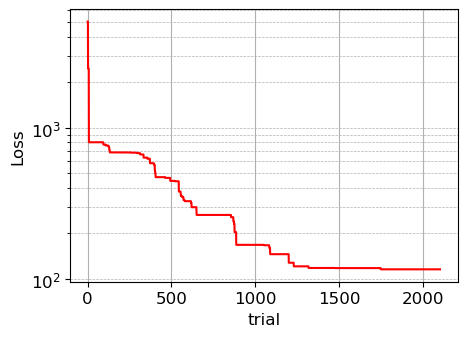

In [202]:
''' 最適化したいデータをdf_optに格納'''
df_opt = [df3_3m, df3_10m, df3_20m, df3_200m]
grain_size = [3e-6, 10e-6, 18e-6, 200e-6]

''' Optunaの設定'''


def objective(trial):
    param = {
        # "sm": trial.suggest_float('sm', 3.5e10, 4.5e10),
        "k": trial.suggest_float('k', 0, 0.1),
        "f": trial.suggest_float('f', 0, 100),
        # "s": trial.suggest_float('s', 0, 10e8),　#切片sを近似的に降伏点とみなすことにする。
        "sf": trial.suggest_float('sf', 0, 10),
        # "alpha": trial.suggest_float('alpha', 0, 100),
        # "beta": trial.suggest_float('beta', 0, 100),
        # 切片s=s0+k0*d^(-1/2)とおき、Hall-petch則のパラメータs0,k0も合わせみの対象とし、粒径を入れればsが決まるようにする。
        "s0": trial.suggest_float('s0', 1e6, 1e9),
        "k0": trial.suggest_float('k0', 0, 1e7)
    }
    error = []  # errorをリセット

    for gs, df in zip(grain_size, df_opt):
        d = Twip(sm=4e10, d=gs, s=param["s0"]+param["k0"]*gs **
                 (-0.5), k=param["k"], f=param["f"], sf=param["sf"])
        ips, sigs = d.twip_main(0, 1.5, 151, plot_option=False)
        result = pd.DataFrame(columns=["ips", "sigs"])
        result["ips"] = ips.round(2)
        result["sigs"] = sigs

        for i in range(len(df.index)):
            df.iloc[i, 3] = result["sigs"].loc[(
                df.iloc[i, 0] == result.ips)].values.astype("float")

        error.append(func_error(df))

    return sum(error)


if __name__ == '__main__':
    # studyオブジェクト生成
    random_sampler = optuna.samplers.RandomSampler()
    study = optuna.create_study(direction="minimize", sampler=random_sampler)

    # 最適化実行
    optuna.logging.disable_default_handler()

    study.optimize(objective, n_trials=100)

    study.sampler = optuna.samplers.TPESampler()
    study.optimize(objective, n_trials=2000)

    epoches = []    # 試行回数格納用
    values = []    # best_value格納用
    best = 100000    # 適当に最大値を格納しておく
    # best更新を行う
    for i in study.trials:
        if best > i.value:
            best = i.value
        epoches.append(i.number+1)
        values.append(best)

    # グラフ設定等
    plt.rcParams["font.size"] = 12
    plt.figure(figsize=(5, 3.54), dpi=100)
    plt.plot(epoches, values, color="red")
    plt.xlabel("trial"), plt.ylabel("Loss"), plt.grid()
    plt.yscale("log")
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    plt.show()

In [203]:
print("Best parameters: ", study.best_params)
print("Best value: ", study.best_value)

Best parameters:  {'k': 0.061040642836173664, 'f': 6.05157398048324, 'sf': 0.345627042070125, 's0': 41049277.14016845, 'k0': 188023.60004067267}
Best value:  115.52678984432126


## SSカーブへの粒径への影響

In [204]:
result_d = pd.DataFrame(index=range(0, 201), columns=(
    ["3μm", "10μm", "18μm", "200μm"]))

In [205]:
d_list = [3e-6, 10e-6, 18e-6, 200e-6]

# best_sm = study.best_params["sm"]
best_k = study.best_params["k"]
best_f = study.best_params["f"]
best_sf = study.best_params["sf"]
# best_alpha = study.best_params["alpha"] #粒径への感度追加
# best_beta = study.best_params["beta"] #双晶間隔への感度追加
best_s0 = study.best_params["s0"]
best_k0 = study.best_params["k0"]

for i, d in enumerate(d_list):
    d = Twip(sm=4e10, d=d, s=best_s0+best_k0*d**(-0.5),
             k=best_k, f=best_f, sf=best_sf)  # Optunaでの最適数値で置き換え
    ips, sigs = d.twip_main(0, 2.0, 201, plot_option=False)

    result_d.iloc[:, i] = sigs
    result_d["ips"] = ips.round(2)

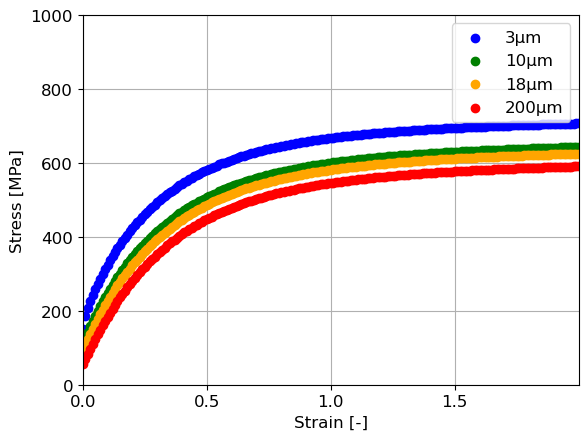

In [206]:
x = result_d.ips

fig, ax = plt.subplots()

ax.scatter(x=x, y=result_d["3μm"], color="blue", label="3μm", zorder=2)
ax.scatter(x=x, y=result_d["10μm"], color="green", label="10μm", zorder=2)
ax.scatter(x=x, y=result_d["18μm"], color="orange", label="18μm", zorder=2)
ax.scatter(x=x, y=result_d["200μm"], color="red", label="200μm", zorder=2)

plt.ylim([0, 1000])
plt.xlim([0, 2])
plt.xticks(np.arange(0, 2, 0.5))
plt.grid(True, zorder=1)
plt.ylabel("Stress [MPa]")
plt.xlabel("Strain [-]")

ax.legend()
plt.show()

In [207]:
result_d

,3μm,10μm,18μm,200μm,ips
0,150.084753,100.98756,85.846865,54.824553,0.00
1,186.494858,125.309648,106.491349,68.357739,0.01
2,207.883614,142.570223,122.649138,82.882076,0.02
3,226.307279,158.227208,137.613839,96.932365,0.03
4,243.054092,172.918118,151.816733,110.543253,0.04
...,...,...,...,...,...
196,706.247192,642.447472,624.412641,590.052629,1.96
197,706.430111,642.643604,624.61177,590.255581,1.97
198,706.610881,642.83738,624.808493,590.456058,1.98
199,706.789534,643.028835,625.002846,590.654097,1.99


# (4) TWIPパラメータの組成からの予測モデル構築

### 教師データの準備

In [118]:
indices = ['PureCu', 'Cu10Zn', "Cu20Zn", "Cu30Zn"]
columns = ["Zn", "d", "k", "f", "sf", "s0", "k0"]

df_train = pd.DataFrame(index=indices, columns=columns)
'''Sm削除、粒径追加、α、β削除'''

PureCu = {
    'Zn': 0, 'd': 200e-6, 'k': 3.80e-2,
    'f': 6.54, 'sf': 4.02e-1, 's0': 1.84e7, 'k0': 6.00e5
}

Cu10Zn = {
    'Zn': 10, 'd': 200e-6, 'k': 1.11e-2,
    'f': 2.69, 'sf': 3.19, 's0': 9.37e7, 'k0': 4.41e4
}

Cu20Zn = {
    'Zn': 20, 'd': 200e-6, 'k': 4.28e-2,
    'f': 3.30, 'sf': 1.52e-1, 's0': 3.67e7, 'k0': 1.92e5
}

Cu30Zn = {
    'Zn': 30, 'd': 200e-6, 'k': 3.23e-3,
    'f': 3.15e-2, 'sf': 5.30, 's0': 7.27e7, 'k0': 1.50e5
}

data = [PureCu, Cu10Zn, Cu20Zn, Cu30Zn]


In [119]:
for index, data in zip(indices, data):
    df_train.loc[index] = data

In [120]:
df_train

,Zn,d,k,f,sf,s0,k0
PureCu,0.0,0.0002,0.038,6.54,0.402,18400000.0,600000.0
Cu10Zn,10.0,0.0002,0.0111,2.69,3.19,93700000.0,44100.0
Cu20Zn,20.0,0.0002,0.0428,3.3,0.152,36700000.0,192000.0
Cu30Zn,30.0,0.0002,0.00323,0.0315,5.3,72700000.0,150000.0


In [121]:
y_train = df_train.iloc[[0, 1, 3], 2:].values  # Cu-20Zn以外を教師データとする
x_train = df_train.iloc[[0, 1, 3], :2].values  # 組成は、純　銅（Zn＝０％）、Cu-10Zn、Cu-30Zn

y_test = df_train.iloc[:, 2:].values
x_test = df_train.iloc[:, :2].values

In [122]:
x_test

array([[0.0, 0.0002],
       [10.0, 0.0002],
       [20.0, 0.0002],
       [30.0, 0.0002]], dtype=object)

## データの標準化

In [123]:
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()
y_train_s = scaler_y.fit_transform(y_train)
y_test_s = scaler_y.transform(y_test)

scaler_x = StandardScaler()
x_train_s = scaler_x.fit_transform(x_train)
x_test_s = scaler_x.transform(x_test)

## Neural Networkモデル構築

In [124]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(30, 30, 30),
                     random_state=1)  # 100ユニット3層のNeural Networkモデル
model.fit(x_train_s, y_train_s)

MLPRegressor(hidden_layer_sizes=(30, 30, 30), random_state=1)

## Neural Networkで推算したTWIPパラメータによるSSカーブ

In [117]:
x_test_new = np.array(
    [[0, 200e-6], [10, 200e-6], [15, 200e-6], [20, 200e-6], [30, 200e-6]])
x_test_new_s = scaler_x.transform(x_test_new)

In [125]:
y_test_new_s = model.predict(x_test_new_s)
y_test_new = scaler_y.inverse_transform(y_test_new_s)

df_predict = pd.DataFrame(data=y_test_new, index=[
                          "PureCu", "Cu10Zn", "Cu15Zn", "Cu20Zn", "Cu30Zn"], columns=["k", "f", "sf", "s0", "k0"])

In [126]:
df_predict  # Cu-20Znは学習に使っていないデータ

,k,f,sf,s0,k0
PureCu,0.037820,6.596292,0.343947,1.809313e+07,592914.127250
Cu10Zn,0.011668,2.566597,3.341082,9.481810e+07,63813.370151
Cu15Zn,0.007947,1.326834,4.251712,9.527944e+07,58436.763802
Cu20Zn,0.006171,0.842935,4.802683,8.791025e+07,82828.287316
Cu30Zn,0.002943,0.066526,5.230601,7.215245e+07,141706.730210


In [127]:
N = 151

result_pre = pd.DataFrame(index=range(0, N), columns=(
    ["pure_Cu", "Cu-10Zn", "Cu-15Zn", "Cu-20Zn", "Cu-30Zn"]))

In [130]:
k_list = df_predict.iloc[:, 0]
f_list = df_predict.iloc[:, 1]
sf_list = df_predict.iloc[:, 2]
s0_list = df_predict.iloc[:, 3]
k0_list = df_predict.iloc[:, 4]

gs = 200e-6
for i, (k, f, sf, s0, k0) in enumerate(zip(k_list, f_list, sf_list, s0_list, k0_list)):
    d = Twip(sm=4e10, d=gs, s=s0+k0*gs**(-0.5), k=k, f=f, sf=sf)
    ips, sigs = d.twip_main(0, 1.5, N, plot_option=False)

    result_pre.iloc[:, i] = sigs
    result_pre["ips"] = ips.round(2)

In [131]:
result_pre

,pure_Cu,Cu-10Zn,Cu-15Zn,Cu-20Zn,Cu-30Zn,ips
0,60.498489,99.810384,99.891546,94.247097,82.652631,0.00
1,70.057647,106.603473,106.597006,100.9662,89.140327,0.01
2,79.474303,115.786064,116.443389,111.228017,99.537405,0.02
3,88.513552,124.909733,126.188109,121.348271,109.743532,0.03
4,97.234573,133.952868,135.856924,131.383288,119.862744,0.04
...,...,...,...,...,...,...
146,395.48987,508.329352,593.485191,630.02108,697.777627,1.46
147,395.870115,508.705401,594.446226,631.386326,700.14012,1.47
148,396.245936,509.074148,595.396479,632.740469,702.494731,1.48
149,396.617405,509.435738,596.336087,634.083626,704.841539,1.49


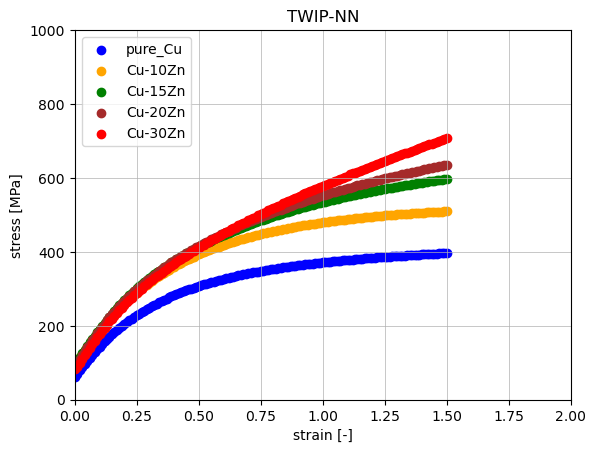

In [134]:
x = result_pre.ips

fig, ax = plt.subplots()

ax.scatter(x=x, y=result_pre["pure_Cu"], color="blue", label="pure_Cu")
ax.scatter(x=x, y=result_pre["Cu-10Zn"], color="orange", label="Cu-10Zn")
ax.scatter(x=x, y=result_pre["Cu-15Zn"], color="green", label="Cu-15Zn")
ax.scatter(x=x, y=result_pre["Cu-20Zn"], color="brown", label="Cu-20Zn")
ax.scatter(x=x, y=result_pre["Cu-30Zn"], color="red", label="Cu-30Zn")

plt.title("TWIP-NN")
plt.xlabel("strain [-]"), plt.xlim([0, 2])
plt.ylabel("stress [MPa]"), plt.ylim([0, 1000])
plt.grid(linewidth=0.5)

ax.legend(loc='upper left')
plt.show()

## 文献値（比較用）

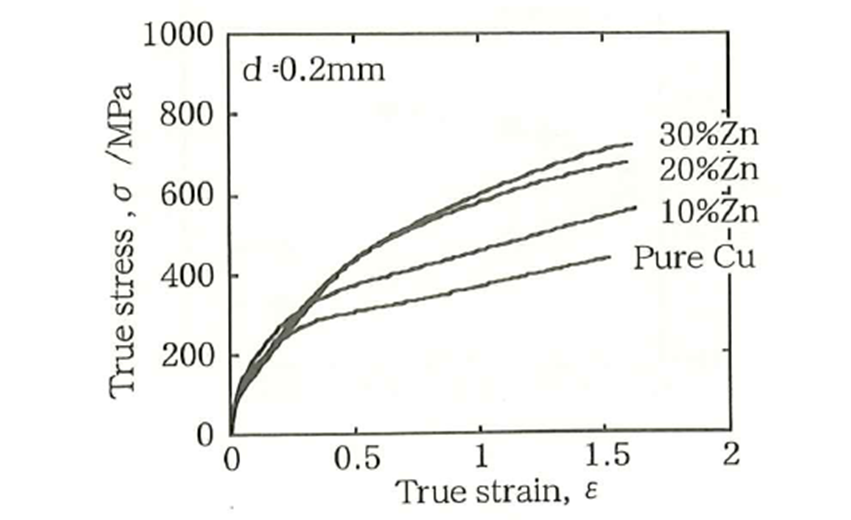!